# The surprising effectivness of simple steering vectors

Write-up see [here.](https://github.com/ArborProject/arborproject.github.io/issues/8)

## Setup

### NDIF

Because `DeepSeek-R1-Distill-Llama-8B` is still too large, these findings cannot be repoduced on the free colab GPU. Fortunately, you can use [NDIF](https://ndif.us/start.html)!

NDIF is an inference service dedicated to hosting the largest open-weight LLMs for researchers to crack them open. Using the NNsight Python API, you can express your interventions, with minimal setup and resources, to execute them remotely during the model's runtime, without bearing the cost or headache of loading and running the model in your local environment.

To get started, install the NNsight library.

Next, you need to register for an API key which will grant you access to the models hosted on the the remote cluster (NDIF). This is very simple, you just to follow this link: https://login.ndif.us/, which will prompt you to sign up. Once you have your API key run this cell:

### NNsight

In [1]:
import nnsight
import torch as t

model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# instantiate the model using the LanguageModel class
lm = nnsight.LanguageModel(model_name,device_map = 'auto',dispatch=True)
tokenizer = lm.tokenizer

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# I precomputed some R1-Llama-8B responses for us

In [2]:
from utils import *
from wrapper import *
from huggingface_hub import hf_hub_download

file_name = hf_hub_download(
    repo_id="wendlerc/GSM8K_solutions_of_DeepSeek-R1-Distill-Llama-8B",
    filename="gsm8k_responses_test.jsonl",
    repo_type="dataset"
)
print(f"File downloaded to: {file_name}")
r1_responses = load_jsonl(file_name)

File downloaded to: /export/home2/weijie210/.cache/huggingface/hub/datasets--wendlerc--GSM8K_solutions_of_DeepSeek-R1-Distill-Llama-8B/snapshots/e1d6c21d1905bbcc37297e762dbb30a4105c78e8/gsm8k_responses_test.jsonl


In [ ]:
pprint(r1_responses[0]['r1_full'])

# Compute steering vectors

In [3]:
from copy import deepcopy
import numpy as np
import re

def preprocess_answers(answers, n_steer=200, n_eval=200):
  responses_by_question = {}
  for idx, example in enumerate(answers[:n_steer + n_eval]):
      answer_str = example["answer"].split("#### ")[1].strip()
      answer_str_tmp = deepcopy(answer_str)
      if ',' in answer_str:
          answer_str_tmp = answer_str_tmp.replace(',', '.')
      # if '.' is contained twice, remove the second one
      if answer_str_tmp.count('.') > 1:
          answer_str_tmp = answer_str_tmp.replace('.', '')
      try:
          answer_float = float(answer_str_tmp)
      except:
          print(f"Failed to convert {answer_str_tmp} to float")
          answer_float = 0.
          continue

      # Extract the response text
      response_text = example["r1_full"]

      # Find all occurrences of numbers matching the answer within <think> tags
      think_start = response_text.find("<think>")
      think_end = response_text.find("</think>")

      if think_start != -1 and think_end != -1:
          think_content = response_text[think_start:think_end]

          # Initialize entry for this question
          responses_by_question[idx] = {
              "asnwer_str":answer_str,
              "answer_float": answer_float,
              "response": response_text,
              "end_indices": [],
              'think_start': think_start,
              'think_end': think_end,
          }

          # Create partial responses up to each occurrence of the answer
          last_pos = 0
          while True:
              # Find next occurrence of answer after last position
              pos = think_content.find(answer_str, last_pos)
              if pos == -1:
                  break

              # Find the end of the sentence after this occurrence
              # Look for various sentence endings (. ? ! ;)
              endings = ['.', '?', '!', ';', '\n']
              sentence_end = -1
              for ending in endings:
                  end_pos = think_content.find(ending, pos)
                  if end_pos != -1:
                      if sentence_end == -1 or end_pos < sentence_end:
                          sentence_end = end_pos

              if sentence_end == -1:
                  sentence_end = len(think_content)
              else:
                  sentence_end += 1  # Include the punctuation mark

              # Store the end index
              responses_by_question[idx]["end_indices"].append(think_start + sentence_end)

              last_pos = pos + 1
  responses = list(responses_by_question.values()) # yes i know this is ugly
  responses_steer = responses[:n_steer]
  responses_eval = responses[n_steer:]
  return responses_steer, responses_eval


def check_answer(responses):
    acc = []
    sample_result = {}
    for i,r in enumerate(responses):
        ans = r['answer'].split('####')[-1].strip()
        if ',' in ans:
            ans = ans.replace(',','')
        ans = int(ans)

        res = r['r1_full']
        try:
            ans_ctx = res.split("</think>")[-1]
        except:
            ans_ctx = -1

        if ans_ctx != -1:
            ans_start = ans_ctx.find('boxed{') + 6
            if ans_start != -1:
                ans_end = ans_ctx[ans_start:].find('}')
                pred_ans = ans_ctx[ans_start:ans_start + ans_end].strip()
                pred_ans = re.sub(r"\D","",pred_ans) # remove non-digit
                if ',' in pred_ans:
                    pred_ans = pred_ans.replace(',','')
                if '.' in pred_ans:
                    try:
                        pred_ans = float(pred_ans)
                    except:
                        pass
                else:
                    try:
                        pred_ans = int(pred_ans)
                    except:
                        pass
                if isinstance(pred_ans,str):
                    correct = str(ans) == pred_ans
                else:
                    correct = pred_ans == ans
                acc.append(correct)
                # if not correct:
                #     print (pred_ans,ans)
                sample_result[i] = correct
    print (f'acc: {np.mean(acc)}, num evaluated: {len(acc)}/{len(responses)}')
    return sample_result


In [20]:
# check acc and get samples where ans is wrong
sample_result = check_answer(r1_responses)

acc: 0.8923426838514026, num evaluated: 1319/1319


In [4]:
load_flag = False # by setting this to True you can skip this step and just load a steering vector that I computed
n_steer = 20 # if you have some time you can increase these numbers...
n_eval = 5

In [5]:
# collect latents
from tqdm import tqdm
import random
from collections import defaultdict

if load_flag:
  from huggingface_hub import hf_hub_download
  file_name = hf_hub_download(
      repo_id="wendlerc/DeepSeek-R1-Distill-Llama-8B_steer_towards_reconsider_or_finish",
      filename="gsm8k_steer_on_dot_towards_wrapping_up.pt",
      repo_type="model"
  )
  print(f"File downloaded to: {file_name}")
  vecs = t.load(file_name, weights_only=False)
  print(vecs.shape, "there is one steering vector per layer")
else:
  responses_steer, responses_eval = preprocess_answers(r1_responses, n_steer=n_steer, n_eval=n_eval)
  prompter = R1Prompter()

  N_LAYERS = len(lm.model.layers)

  cnt = 0
  latents = []
  for r in responses_steer:
      if len(r['end_indices']) > 1:
          cnt += 1
          last_idx = r['end_indices'][-2]#-1 # set to -2 as -1 is the answer within the thinking
          # sample a random index from the list of end indices
          idx = r['end_indices'][random.randint(0, len(r['end_indices'])-2)]
          idx = r['end_indices'][0]

          # Get the text up to the sampled index and last index
          text_to_idx = r["response"][:idx]
          text_to_last = r["response"][:last_idx]


          # Encode to get token indices without adding special tokens
          tokens_to_idx = lm.tokenizer.encode(text_to_idx, add_special_tokens=False)
          tokens_to_last = lm.tokenizer.encode(text_to_last, add_special_tokens=False)

          positive_token_idx = len(tokens_to_idx)-1 # positive = wait # both are endings just at different steps (this is intermediate)
          negative_token_idx = -1 # negative = continue (last thinking step)

          # collect latents
          with t.no_grad():
              with lm.trace(tokens_to_last) as tracer:
                  hs = [(lm.model.layers[layer_idx].output[0][0, positive_token_idx].detach().cpu().save(),
                        lm.model.layers[layer_idx].output[0][0, negative_token_idx].detach().cpu().save()) for layer_idx in range(N_LAYERS)]
          hs = [(pos.cpu(), neg.cpu()) for pos, neg in hs]
          latents += [hs]

  print(f"We used {cnt}/{len(responses_steer)} of the GSM8K examples to compute our steering vectors")
  pos_dict = defaultdict(list)
  neg_dict = defaultdict(list)

  for hs in latents:
      for idx, layer in enumerate(hs):
          pos_dict[idx].append(layer[0])
          neg_dict[idx].append(layer[1])

  vecs = []
  for lidx in sorted(list(pos_dict.keys())):
    vec = t.stack(pos_dict[lidx]).mean(dim=0) - t.stack(neg_dict[lidx]).mean(dim=0)
    vecs += [vec]
  vecs = t.stack(vecs).to('cuda')
  print(vecs.shape, "there is one steering vector per layer")


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


We used 17/20 of the GSM8K examples to compute our steering vectors
torch.Size([32, 4096]) there is one steering vector per layer


In [27]:
## use Final Ans to get the context prior to finishing thought and steer to think more, see if it helps get ans correct from wrong.
layers_to_steer = list(range(12,16))
wrong_ids = [k for k,v in sample_result.items() if not v]
wrong_samples = [r1_responses[i] for i in wrong_ids]
new_tokens = 1000
# processed_samples,_ = preprocess_answers(correct_samples,len(correct_samples),0)
# filtered_samples = [d for d in processed_samples if len(d['end_indices']) > 3] # filter away cases where the thought process dont arrive at answer multiple times.

wrong_samples = [d for d in wrong_samples if 'Final Answer' in d['r1_full']]

# 1) Test if steering it to think again for all samples will worsen performance or not.
Since we prompt it again to produce the answer, need to reprompt (without steering) to get the baseline performance then compare to steering.

# 2) Look at attention scores of the next tokens after each solution is computed (look at paragraph split by newline)
Check by top 3 attention heads (averaged across all input tokens), and then averaged across all output tokens in the next paragraph, split context by intervals of 20%, to check for recency. (if model always look at most recent context, we can use mistake insertion to double check if adding mistake causes effects on the next paragraph.)


In [ ]:
steer_results = defaultdict(list)
for sample in tqdm(wrong_samples,total = len(wrong_samples)):
    response = sample['r1_full']
    truncated_ = '\n\n'.join(response.split('Final Answer')[0].split('\n\n')[:-1])
    true_answer = sample['answer'].split("#### ")[1].strip()
    if ',' in true_answer:
        true_answer = true_answer.replace(',','')
    tokens = [lm.tokenizer.encode(truncated_,add_special_tokens=False) for _ in layers_to_steer]

    with lm.generate(tokens, max_new_tokens=new_tokens, do_sample=False) as tracer, t.no_grad(): # process all layers at once
        # with lm.model.all():
        for i,layer in enumerate(layers_to_steer):  # only steer at last token once
            lm.model.layers[layer].output[0][i,-1:] += 2.0*vecs[layer].unsqueeze(0)
        gen_toks = lm.generator.output.save()
    generated_text = [lm.tokenizer.decode(g[-new_tokens:]) for g in gen_toks]

    for i,g in enumerate(generated_text):
        if lm.tokenizer.eos_token in g:
            generated_text[i] = g.split(lm.tokenizer.eos_token)[0].strip()
        generated_text[i] += '\nSo the final answer is \\boxed{'
    
    # gather final answer from truncated CoT.
    answer_input = [tt+g for tt,g in zip(truncated_,generated_text)]

    # pprint (answer_input[0])
    answer_tokens = [lm.tokenizer.encode(tt,add_special_tokens=False) for tt in answer_input]
    with lm.generate(answer_tokens, max_new_tokens=10, do_sample=False) as tracer, t.no_grad():
        gen_toks = lm.generator.output.save()
    generated_text = [lm.tokenizer.decode(g[-10:]) for g in gen_toks]
    for i,pred in enumerate(generated_text):
        if '}' in pred:
            pred = pred.split('}')[0].strip()
        if ',' in pred:
            pred = pred.replace(',','')
        correct = true_answer in pred
        if not correct:
            pprint (f'pred: {pred},ans: {true_answer}')
        steer_results[layers_to_steer[i]].append(correct)

steer_results = {k: np.mean(v) for k,v in steer_results.items()}
print (steer_results)


In [144]:
print (steer_results)

NameError: name 'steer_results' is not defined

# Patchscope lensing the steering vectors

In [48]:
def patch_scope_lens(lm, vector, lidx, target_prompt=None):
    if target_prompt is None:
        target_prompt = "cat -> cat\n1135 -> 1135\nhello -> hello\n? -> "

    with lm.trace(target_prompt), t.no_grad():
        lm.model.layers[lidx].output[0][:,-1,:] = vector
        logits = lm.lm_head.output[:, -1, :].cpu().save()

    return logits

In [ ]:
print("Patchscope lens (slow)")
for lidx in range(0, 32):
    logits = patch_scope_lens(lm, vecs[lidx], lidx)
    logits = logits[0]
    top_tokens = t.topk(logits, k=5)
    print(f"Layer {lidx} (reconsider direction):")
    for i in range(5):
        token = lm.tokenizer.decode(top_tokens.indices[i])
        prob = t.softmax(logits, dim=-1)[top_tokens.indices[i]].item()
        print(f"  {i+1}. {token} ({prob:.3f})")

for lidx in range(0, 32):
    logits = patch_scope_lens(lm, -vecs[lidx], lidx)
    logits = logits[0]
    top_tokens = t.topk(logits, k=5)
    print(f"Layer {lidx} (finish direction):")
    for i in range(5):
        token = lm.tokenizer.decode(top_tokens.indices[i])
        prob = t.softmax(logits, dim=-1)[top_tokens.indices[i]].item()
        print(f"  {i+1}. {token} ({prob:.3f})")

# Steering

In [9]:
load_flag = False # by setting this to True you can skip this step and just load the steered responses that I precomputed

verbose = True
output_file = 'gsm8k_steer_on_dot_train_test_split.jsonl'
n_new_toks = 250
do_sample = False
alpha1 = 1.5
alpha2 = 1.0
alpha3 = 1.0
layer_idcs = range(12, 16) # these layers are effective

In [10]:
if load_flag:
    file_name = hf_hub_download(
        repo_id="wendlerc/Steering-R1-Llama-8B_on_GSM8K",
        filename="gsm8k_steer_on_dot_train_test_split.jsonl",
        repo_type="dataset"
    )
    print(f"File downloaded to: {file_name}")
    steering_examples = load_jsonl(file_name)
else:
    from copy import deepcopy
    import json
    for r in responses_eval:
        if len(r['end_indices']) > 1:
            cnt += 1
            last_idx = r['end_indices'][-2]
            # sample a random index from the list of end indices
            first_idx = r['end_indices'][1] #random.randint(0, len(r['end_indices'])-1)]
            middle_idx = r['end_indices'][(len(r['end_indices'])-1)//2]

            # Get the text up to the sampled index and last index
            text_to_first = r["response"][:first_idx]
            text_to_middle = r["response"][:middle_idx]
            text_to_last = r["response"][:last_idx]

            # Encode to get token indices without adding special tokens
            tokens_to_first = lm.tokenizer.encode(text_to_first, add_special_tokens=False)
            tokens_to_middle = lm.tokenizer.encode(text_to_middle, add_special_tokens=False)
            tokens_to_last = lm.tokenizer.encode(text_to_last, add_special_tokens=False)

            # Create output dictionary with original fields
            output = r.copy()
            output['generated_continuations'] = {
                'first': [],
                'middle': [],
                'last': []
            }

            # Generate continuations for first text
            # if verbose:
            #     print("Full response:")
            #     pprint(r['response'])
            #     print("Partial response from which we continue:")
            #     pprint(text_to_first)
            
            with lm.generate(tokens_to_first, max_new_tokens=n_new_toks, do_sample=do_sample) as tracer, t.no_grad():
                gen_toks = lm.generator.output.save()
            original_text = lm.tokenizer.decode(gen_toks[0][-n_new_toks:])
            pprint (f'original gen: {original_text}')

            for layer_idx in layer_idcs:
                toks = deepcopy(tokens_to_first)
                with lm.generate(toks, max_new_tokens=n_new_toks, do_sample=do_sample) as tracer, t.no_grad():
                    with lm.model.all():
                        lm.model.layers[layer_idx].output[0][:,-1:] -= alpha1*vecs[layer_idx].unsqueeze(0).cuda()
                    gen_toks = lm.generator.output.save()
                generated_text = lm.tokenizer.decode(gen_toks[0][-n_new_toks:])
                output['generated_continuations']['first'].append({
                    'layer': layer_idx,
                    'text_idx': first_idx,
                    'text': generated_text
                })
                if verbose:
                    pprint(f'first layer {layer_idx} (steered towards wrapping up):\n{generated_text}')
            break
            

    #         # Generate continuations for middle text
    #         if verbose:
    #             pprint(text_to_middle)
    #         for layer_idx in layer_idcs:
    #             toks = deepcopy(tokens_to_middle)
    #             with lm.generate(toks, max_new_tokens=n_new_toks, do_sample=do_sample, temperature=0.6,) as tracer,t.no_grad():
    #                 with lm.model.all():
    #                     lm.model.layers[layer_idx].output[0][:,-1:] -= alpha2*vecs[layer_idx].unsqueeze(0).cuda()
    #                 gen_toks = lm.generator.output.save()
    #             generated_text = lm.tokenizer.decode(gen_toks[0][-n_new_toks:])
    #             output['generated_continuations']['middle'].append({
    #                 'text_idx': middle_idx,
    #                 'layer': layer_idx,
    #                 'text': generated_text
    #             })
    #             if verbose:
    #                 print(f'middle layer {layer_idx} (steered towards wrapping up):\n{generated_text}')

    #         # Generate continuations for last text

            # if verbose:
                # pprint(text_to_last)
            
            # with lm.generate(tokens_to_last, max_new_tokens=n_new_toks, do_sample=do_sample) as tracer, t.no_grad():
            #     gen_toks = lm.generator.output.save()
            # original_text = lm.tokenizer.decode(gen_toks[0][-n_new_toks:])
            original_text = r["response"][last_idx:]
            # print (f'original gen: {original_text}')
            
            toks = deepcopy(tokens_to_last)
            with lm.generate([toks for _ in layer_idcs], max_new_tokens=n_new_toks, do_sample=do_sample,) as tracer,t.no_grad():
                # with lm.model.all():
                for i,layer_idx in enumerate(layer_idcs):
                    lm.model.layers[layer_idx].output[0][i,-1:] += 5.0*vecs[layer_idx].unsqueeze(0).cuda()
                gen_toks = lm.generator.output.save()
            generated_text = [lm.tokenizer.decode(g[-n_new_toks:]) for g in gen_toks]
            output['generated_continuations']['last'].append({
                'layer': layer_idx,
                'text_idx': last_idx,
                'text': generated_text
            })
            if verbose:
                for i,layer_idx in enumerate(layer_idcs):
                    print(f'last layer {layer_idx} (steered towards continuation):\n{generated_text[i]}')
            break

    #         # Write to jsonl file in append mode
    #         with open(output_file, 'a') as f:
    #             f.write(json.dumps(output) + '\n')

    # steering_examples = load_jsonl(output_file)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ original gen:  So, water in pineapple drink = (3/5) * 15 liters.                                 │
│                                                                                                  │
│ Calculating that, 3/5 of 15 is (3 * 15)/5 = 45/5 = 9 liters. So, 9 liters of water in the        │
│ pineapple drink.                                                                                 │
│                                                                                                  │
│ Now, if I were to mix them without spilling, the total water would be the sum of the water from  │
│ both drinks. So, 20/3 liters + 9 liters.                                                         │
│                                                                                                  │
│ Let me convert 9 liters to thirds to add them. 9 liters is 27/3 liters. So, 20/3 + 27/3 = 47/3   │
│ liters of water. That's approximately 15.666... liters.                                          │
│                                                                                                  │
│ But wait, I spilled one liter of the orange drink. So, I need to adjust for that. The spilled    │
│ liter is part of the orange drink, which is two-thirds water. So, how much water did I spill?    │
│                                                                                                  │
│ Since the orange drink is two-thirds water, one liter of it would contain (2/3) * 1 liter = 2/3  │
│ liters of water. So, I lost 2/3 liters of water when I spilled that liter.                       │
│                                                                                                  │
│ Therefore, the total water in                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ first layer 12 (steered towards wrapping up):                                                    │
│ 24 liters.                                                                                       │
│                                                                                                  │
│ Hmm, okay. So, I need to figure out the total amount of water in the final mixture after         │
│ spilling one liter of orange drink. Let me break it down.                                        │
│                                                                                                  │
│ First, let's find out how much water is in the original orange drink. It says it's two-thirds    │
│ water. So, if I have 10 liters of orange drink, two-thirds of that is water. Let me compute      │
│ that.                                                                                            │
│                                                                                                  │
│ Water in orange drink = (2/3) * 10 liters.                                                       │
│                                                                                                  │
│ Calculating that, 2/3 of 10 is (2 * 10)/3 = 20/3 liters, which is approximately 6.666... liters. │
│ Hmm, but I'll keep it as a fraction for accuracy. So, 20/3 liters of water from the orange       │
│ drink.                                                                                           │
│                                                                                                  │
│ Next, the pineapple drink. It's 15 liters, and it's three-fifths water. So, I need to find how   │
│ much water is in the pineapple drink before any spilling.                                        │
│                                                                                                  │
│  Let me note down the steps:                                                                     │
│                                                                                                  │
│  1. Calculate the water in the orange drink.                                                     │
│  2. Calculate the water in the pineapple drink. 3. Then, figure out the total water after adding │
│ everything.                                                                                      │
│                                                                                                  │
│                                                                                                  │
│                                                                                                  │
│                                                                                                  │
│                                                                                                  │
│ <｜end▁of▁sentence｜>                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ first layer 13 (steered towards wrapping up):                                                    │
│  pineapple drink, which is three-fifths water. But as I pour it, I spill one liter of the orange │
│ drink. The question is, how much water is in the remaining 24 liters.                            │
│                                                                                                  │
│ Hmm, okay. So, I need to figure out the total amount of water in the final mixture after         │
│ spilling one liter of orange drink. Let me break it down.                                        │
│                                                                                                  │
│ First, let's find out how much water is in the original orange drink. It says it's two-thirds    │
│ water. So, if I have 10 liters of orange drink, two-thirds of that is water. Let me compute      │
│ that.                                                                                            │
│                                                                                                  │
│ Water in orange drink = (2/3) * 10 liters.                                                       │
│                                                                                                  │
│ Calculating that, 2/3 of 10 is (2 * 10)/3 = 20/3 liters, which is approximately 6.666... liters. │
│ Hmm, but I'll keep it as a fraction for accuracy. So, 20/3 liters of water from the orange       │
│ drink.                                                                                           │
│                                                                                                  │
│ Next, the pineapple drink. It's 15 liters, and it's three-fifths water. So, let me compute the   │
│ water content.                                                                                   │
│                                                                                                  │
│  Water in pineapple drink.                                                                       │
│                                                                                                  │
│  I'll write that as 3/5.                                                                         │
│                                                                                                  │
│                                                                                                  │
│                                                                                                  │
│                                                                                                  │
│                                                                                                  │
│ <｜end▁of▁sentence｜>                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ first layer 14 (steered towards wrapping up):                                                    │
│  So, let me compute the water content.                                                           │
│                                                                                                  │
│  Water in pineapple drink.                                                                       │
│                                                                                                  │
│  I'll write it as:                                                                               │
│                                                                                                  │
│  3/5 of 15 liters.                                                                               │
│                                                                                                  │
│  Let me compute that.                                                                            │
│                                                                                                  │
│  3/5 is 0.6, and 15 is a good number. I can compute it as 15 is 3/5, 3/5 is 1, 15 is 3/5, 3/5 is │
│ 0.6, 15 is 3/5, 3/5 is 0.6, 3/5 is 0.6.                                                          │
│                                                                                                  │
│  I think I can compute it as 3/5 * 15. Let me do it step by step.                                │
│                                                                                                  │
│  15 is 10 and 5. 3/5 is 0.6, so 3/5 * 15 is 3/5 * 15. Let me write it as 3/5 * 15. 15 is 3/5,    │
│ 3/5 is 0.6, 3/5 is 0.6, 3/5 is 0.6. I think I can compute it as 3/5 * 15. 3/5 is                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ first layer 15 (steered towards wrapping up):                                                    │
│ 's find out how much water is in the original orange drink. It says it's two-thirds water. So,   │
│ if I have 10 liters of orange drink, two-thirds of that is water. Let me compute that.           │
│                                                                                                  │
│ Water in orange drink = (2/3) * 10 liters.                                                       │
│                                                                                                  │
│ Calculating that, 2/3 of 10 is (2 * 10)/3 = 20/3 liters, which is approximately 6.666... liters. │
│ Hmm, but I'll keep it as a fraction for accuracy. So, 20/3 liters of water from the orange       │
│ drink.                                                                                           │
│                                                                                                  │
│ Next, the pineapple drink. It's 15 liters, and it's three-fifths water. So, I need to compute    │
│ how much water is in the pineapple drink.                                                        │
│                                                                                                  │
│  Water in pineapple drink = (3/5) * 15 liters.                                                   │
│                                                                                                  │
│  Let me compute that.                                                                            │
│                                                                                                  │
│  3/5 of 15 is (3 * 15)/5 = 30/5 = 6 liters.                                                      │
│                                                                                                  │
│  No fractions, that's straightforward.                                                           │
│                                                                                                  │
│  Now, when I pour the orange drink into the pineapple drink, I also have to consider the spill.  │
│ One liter is spilled, so I don't pour all of it into the mixture.<｜end▁of▁sentence｜>           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

# visualize results

In [ ]:
print(len(steering_examples))

# Steering quality
## (sadly this is bit slow, if you do it over my full results file it should take about 20 minutes)

Device set to use cuda:0
3it [18:15, 365.11s/it]


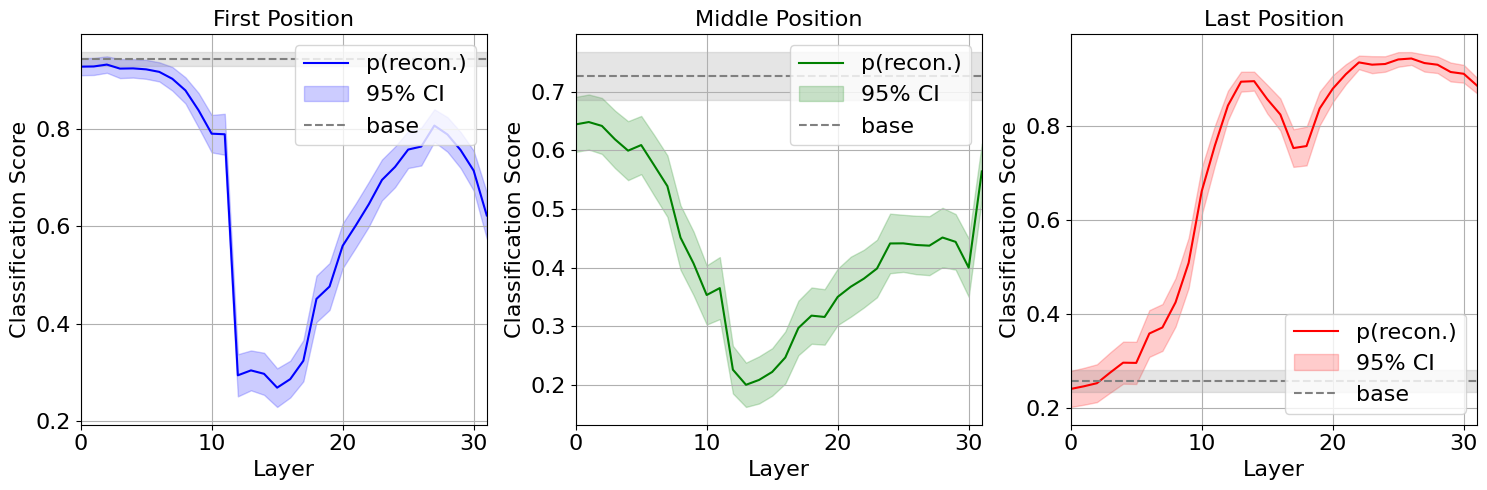

In [ ]:
r1prompter = R1Prompter()
tokenizer = r1prompter.tokenizer

from transformers import pipeline
from typing import List
from tqdm import tqdm

# Initialize zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def classify_text_segments(
    texts: List[str],
    candidate_labels: List[str] = ["Wait. Let me double check.", "I am confident. **Final Answer**"]
) -> List[dict]:
    """
    Classify a list of text segments in a single batch.

    Args:
        texts: List of text segments to classify.
        candidate_labels: Labels to classify between.

    Returns:
        List of classification results dictionaries with fixed label order.
    """
    hypothesis_template = "This is an example of {}"
    results = classifier(
        texts,
        candidate_labels,
        hypothesis_template=hypothesis_template,
        multi_label=False
    )

    # Ensure results is a list even when a single item is classified
    if isinstance(results, dict):
        results = [results]

    processed_results = []
    for result in results:
        ordered_scores = []
        ordered_labels = []
        for label in candidate_labels:
            idx = result['labels'].index(label)
            ordered_scores.append(result['scores'][idx])
            ordered_labels.append(label)
        result['scores'] = ordered_scores
        result['labels'] = ordered_labels
        processed_results.append(result)
    return processed_results

# %%
import numpy as np
from matplotlib import pyplot as plt
experiment_names = ['first', 'middle', 'last']

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
axes = [ax1, ax2, ax3]
colors = ['b', 'g', 'r']

for exp_idx, experiment_name in tqdm(enumerate(experiment_names)):
    baseline_texts = []
    gen_texts = []
    gen_counts = []  # number of generated texts per steering example

    # Accumulate texts for batch processing
    for d in steering_examples:
        gens = d['generated_continuations'][experiment_name]

        # Process baseline text (truncated to ~50 tokens)
        base_toks = tokenizer.encode(d['response'][gens[0]['text_idx']:], add_special_tokens=False)[:50]
        base_text = tokenizer.decode(base_toks)
        baseline_texts.append(base_text)

        # Append all generated texts for this steering example
        for gen in gens:
            gen_texts.append(gen['text'])
        gen_counts.append(len(gens))

    # Batch classify baseline and generated texts
    baseline_results = classify_text_segments(baseline_texts)
    gen_results = classify_text_segments(gen_texts)

    # Reconstruct scores from batch results
    all_baselines = np.array([res['scores'][0] for res in baseline_results])
    all_scores = []
    idx = 0
    for count in gen_counts:
        scores_for_example = [gen_results[idx + j]['scores'][0] for j in range(count)]
        all_scores.append(scores_for_example)
        idx += count
    all_scores = np.array(all_scores)

    # Calculate mean and 95% CI for intervention scores
    mean_scores = np.mean(all_scores, axis=0)
    std_scores = np.std(all_scores, axis=0)
    ci_95 = 1.96 * std_scores / np.sqrt(len(steering_examples))
    upper_ci = mean_scores + ci_95
    lower_ci = mean_scores - ci_95

    # Calculate mean and 95% CI for baseline
    mean_baseline = np.mean(all_baselines)
    std_baseline = np.std(all_baselines)
    baseline_ci = 1.96 * std_baseline / np.sqrt(len(steering_examples))

    # Plot mean line for intervention
    x = np.arange(len(mean_scores))
    axes[exp_idx].plot(x, mean_scores, f'{colors[exp_idx]}-', label='p(recon.)')

    # Plot confidence interval for intervention
    axes[exp_idx].fill_between(x, lower_ci, upper_ci, color=colors[exp_idx], alpha=0.2, label='95% CI')

    # Plot baseline as horizontal line spanning all layers
    axes[exp_idx].axhline(y=mean_baseline, color='gray', linestyle='--', label='base')
    axes[exp_idx].fill_between(x, [mean_baseline - baseline_ci] * len(x),
                               [mean_baseline + baseline_ci] * len(x),
                               color='gray', alpha=0.2)

    # Customize each subplot
    axes[exp_idx].set_xlabel('Layer', fontsize=16)
    axes[exp_idx].set_ylabel('Classification Score', fontsize=16)
    axes[exp_idx].set_xlim(0, 31)
    axes[exp_idx].set_title(f'{experiment_name.capitalize()} Position', fontsize=16)
    if exp_idx == 2:
        axes[exp_idx].legend(loc='lower right', fontsize=16)
    else:
        axes[exp_idx].legend(loc='upper right', fontsize=16)
    axes[exp_idx].grid(True)
    axes[exp_idx].tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()


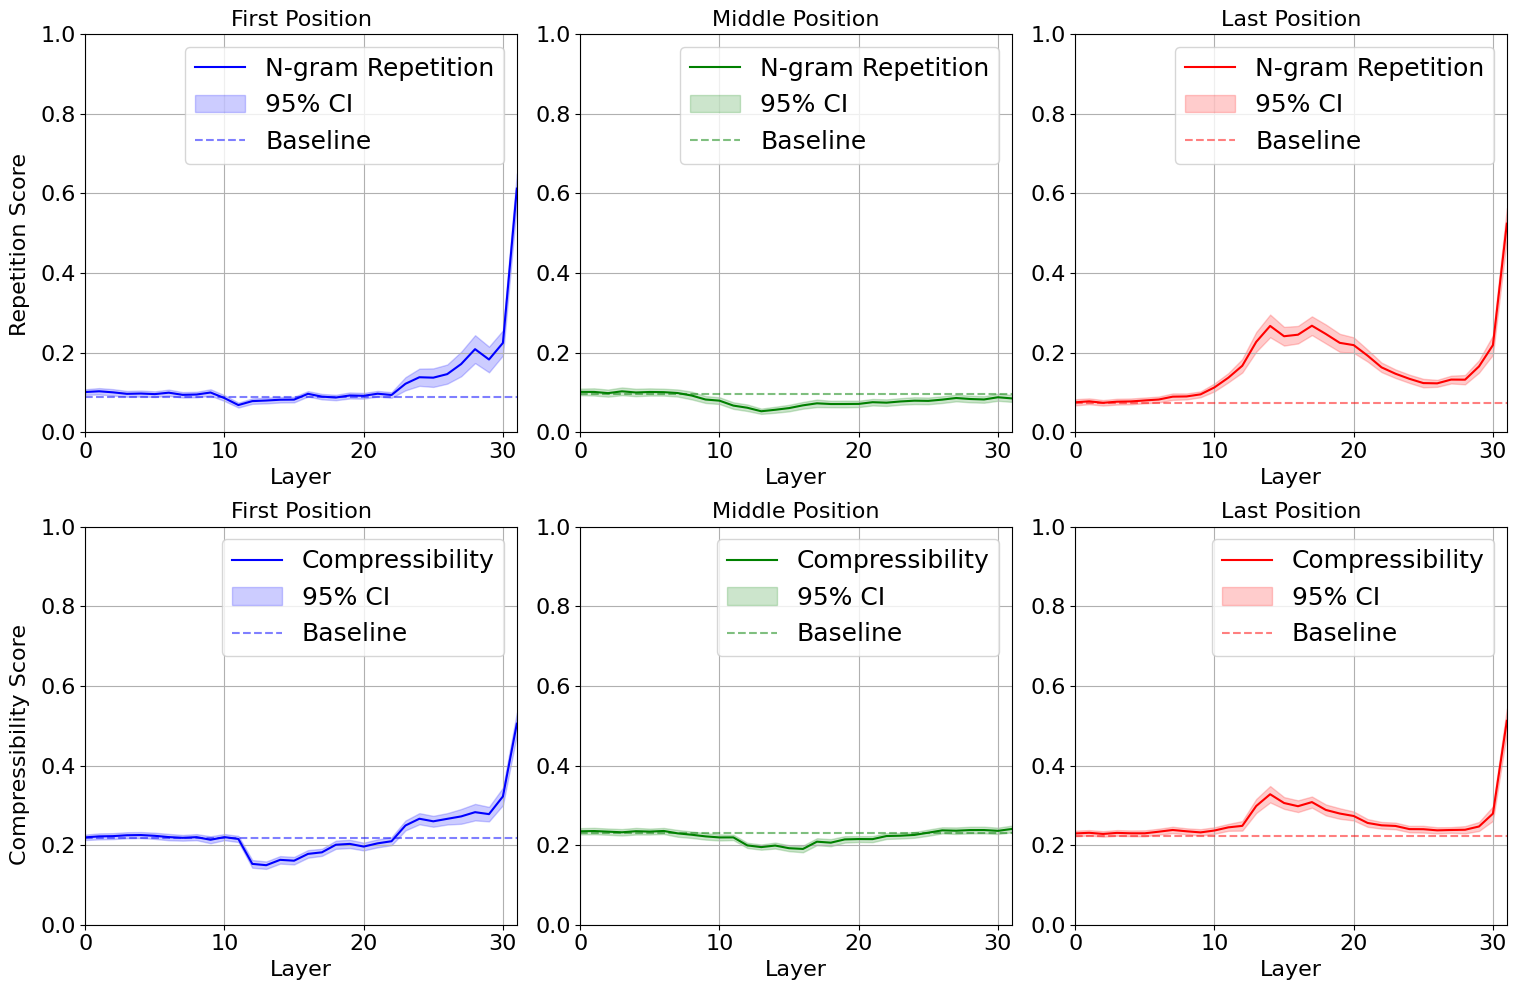

In [ ]:
import zlib

def compute_repetition_penalty(text, tokenizer = r1prompter.tokenizer, weights=None):
    """
    Computes a repetition penalty score using unigrams, bigrams, and trigrams.
    A higher score indicates more repetition.

    Parameters:
      - text (str): The input text.
      - model_name (str): Hugging Face model name for tokenization.
      - weights (dict): Weights for n-gram levels (default: unigrams=0.2, bigrams=0.4, trigrams=0.4).

    Returns:
      - float: The computed repetition penalty score.
    """
    # Default weights if none provided
    if weights is None:
        weights = {1: 0.2, 2: 0.4, 3: 0.4}

    # Tokenize the text (this returns subword tokens; adjust model choice as needed)
    tokens = tokenizer.tokenize(text, add_special_tokens=False)

    def get_ngrams(n):
        return [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

    def repetition_rate(ngrams):
        if not ngrams:
            return 0
        counter = Counter(ngrams)
        # Sum the extra occurrences beyond the first for each n-gram
        extra_occurrences = sum(count - 1 for count in counter.values() if count > 1)
        return extra_occurrences / len(ngrams)

    # Compute a weighted repetition penalty over unigrams, bigrams, and trigrams
    total_penalty = 0
    for n in weights:
        ngrams = get_ngrams(n)
        total_penalty += weights[n] * repetition_rate(ngrams)

    return total_penalty

def compute_repetition_penalty_naive(text):
    # Split text into n-grams (using bigrams and trigrams)
    words = text.lower().split()

    # Calculate n-gram repetition rates
    def get_ngrams(n):
        ngrams = zip(*[words[i:] for i in range(n)])
        return list(ngrams)

    # Get bigrams and trigrams
    # Bigrams capture repeated word pairs like "wait wait" or "hold on hold on"
    # Trigrams catch longer repeated phrases like "let me check again"
    # Using both helps detect different scales of repetition
    bigrams = get_ngrams(2)
    trigrams = get_ngrams(3)

    # Calculate repetition rates as (1 - unique_ngrams/total_ngrams)
    # Higher score means more repetition
    if len(bigrams) > 0:
        bigram_rep = 1 - len(set(bigrams)) / len(bigrams)
    else:
        bigram_rep = 0

    if len(trigrams) > 0:
        trigram_rep = 1 - len(set(trigrams)) / len(trigrams)
    else:
        trigram_rep = 0

    # Weight trigrams more since they catch more meaningful repetition patterns
    return 0.4 * bigram_rep + 0.6 * trigram_rep

def compute_compressibility_score(text):
    """
    Computes a compressibility score for the input text.

    The score is based on the idea that highly repetitive text compresses more.

    Parameters:
      - text (str): The input text.

    Returns:
      - float: A score between 0 and 1, where higher scores indicate easier compression.
    """
    # Encode text as bytes (UTF-8)
    text_bytes = text.encode('utf-8')
    original_length = len(text_bytes)

    # Compress the text using zlib
    compressed_bytes = zlib.compress(text_bytes)
    compressed_length = len(compressed_bytes)

    # Calculate the compression ratio
    ratio = compressed_length / original_length

    # Define the score: higher score means more compressible (i.e., lower ratio)
    score = 1 - ratio

    # Ensure the score isn't negative (which might happen for very short texts)
    score = max(0.0, score)

    return score



# %%
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

tokenizer = r1prompter.tokenizer

experiment_names = ['first', 'middle', 'last']

# Create figure with 6 subplots (2 rows, 3 columns)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
top_axes = [ax1, ax2, ax3]
bottom_axes = [ax4, ax5, ax6]

colors = ['b', 'g', 'r']
for exp_idx, experiment_name in enumerate(experiment_names):
    all_repetition_scores = []
    all_compress_scores = []
    all_repetition_baselines = []
    all_compress_baselines = []
    for idx, d in enumerate(steering_examples):
        gens = d['generated_continuations'][experiment_name]

        base_toks = tokenizer.encode(d['response'][gens[0]['text_idx']:], add_special_tokens=False)
        base_toks = base_toks[:50]
        base_text = tokenizer.decode(base_toks)
        all_repetition_baselines.append(compute_repetition_penalty(base_text))
        all_compress_baselines.append(compute_compressibility_score(base_text))

        repetition_scores = []
        compress_scores = []
        for gen in gens:
            repetition_score = compute_repetition_penalty(gen['text'])
            compress_score = compute_compressibility_score(gen['text'])
            repetition_scores.append(repetition_score)
            compress_scores.append(compress_score)
        all_repetition_scores.append(repetition_scores)
        all_compress_scores.append(compress_scores)

    # Convert to numpy arrays
    all_repetition_scores = np.array(all_repetition_scores)
    all_compress_scores = np.array(all_compress_scores)

    # Calculate mean baselines
    mean_repetition_baseline = np.mean(all_repetition_baselines)
    mean_compress_baseline = np.mean(all_compress_baselines)

    # Calculate means and 95% CIs for all metrics
    for scores, axes, metric_name, baseline in [
        (all_repetition_scores, top_axes, 'N-gram Repetition', mean_repetition_baseline),
        (all_compress_scores, bottom_axes, 'Compressibility', mean_compress_baseline)
    ]:
        mean_scores = np.mean(scores, axis=0)
        std_scores = np.std(scores, axis=0)
        ci_95 = 1.96 * std_scores / np.sqrt(len(steering_examples))
        upper_ci = mean_scores + ci_95
        lower_ci = mean_scores - ci_95

        # Plot mean line
        x = np.arange(len(mean_scores))
        axes[exp_idx].plot(x, mean_scores, f'{colors[exp_idx]}-', label=metric_name)

        # Plot confidence interval
        axes[exp_idx].fill_between(x, lower_ci, upper_ci, color=colors[exp_idx], alpha=0.2, label='95% CI')

        # Plot baseline as horizontal line
        axes[exp_idx].axhline(y=baseline, color=colors[exp_idx], linestyle='--', alpha=0.5, label='Baseline')

        # Customize each subplot
        axes[exp_idx].set_xlabel('Layer', fontsize=16)
        #axes[exp_idx].set_ylabel('Score', fontsize=16)
        axes[exp_idx].set_ylim(0, 1)  # All scores are between 0 and 1
        axes[exp_idx].set_xlim(0, 31)
        axes[exp_idx].set_title(f'{experiment_name.capitalize()} Position', fontsize=16)
        axes[exp_idx].legend(fontsize=18)
        axes[exp_idx].grid(True)
        axes[exp_idx].tick_params(axis='both', which='major', labelsize=16)


# Add row labels
fig.text(-0.01, 0.75, 'Repetition Score', rotation=90, va='center', fontsize=16)
fig.text(-0.01, 0.25, 'Compressibility Score', rotation=90, va='center', fontsize=16)

# Show plot
plt.tight_layout()
plt.show()
